In [126]:
import os
import sys
import json
import importlib
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="ticks", color_codes=True)

import tensorflow as tf
print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Python version: 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


In [4]:
from tensorflow.keras.models import Model
tf.keras.backend.set_floatx('float64')

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense
import tensorflow_probability as tfp
tfd = tfp.distributions

module_path = '/home/lun/project-basileus/time-lstm/time_lstm_modules'
if module_path not in sys.path:
    sys.path.append(module_path)

if 'TimeLSTM' in sys.modules:
    importlib.reload(sys.modules['TimeLSTM'])
    
from TimeLSTM import TimeLSTM0,TimeLSTM1

## Preprocess fixed-length synthesized-data

In [22]:
import pickle

data_path_prefix = '/home/lun/project-basileus/hidden-pattern-detection-skeleton/data/with_oracle/fixed_length'

valid_seqs_filename = 'valid_sequences.pickle'
invalid_seqs_filename = 'invalid_sequences.pickle'

with open(os.path.join(data_path_prefix, valid_seqs_filename), 'rb') as f:
    valid_seqs = pickle.load(f)
    
with open(os.path.join(data_path_prefix, invalid_seqs_filename), 'rb') as f:
    invalid_seqs = pickle.load(f)

In [23]:
event_type_seqs = []
delta_time_seqs = []

for seq in valid_seqs:
    _ets, _dts = [], []
    ts_prev = 0
    for et, ts in seq:
        _ets.append(et) # 0 is for padding, standing for 'N/A' 
        _dts.append(ts-ts_prev)
        ts_prev = ts
    event_type_seqs.append(_ets)
    delta_time_seqs.append(_dts)
        
# label_list = [0] * len(valid_seqs) + [1] * len(invalid_seqs)
label_list = [0] * len(valid_seqs)

## Global Variables

In [37]:
N = len(label_list)
print(N)
DATA_SIZE = 10000  # the actual data size used for training <= N
BATCH_SIZE = 128
VOCAB = ['na', 'start', 'click', 'install']
EMB_DIM = 5
HIDDEN_DIM = 64
END_TOKEN = 0
MAX_TIME = 1024
T = 10

10000


## Create dataset

In [38]:
train_et = np.array(event_type_seqs).astype(np.float64).reshape((N, T, 1))
train_ts = np.array(delta_time_seqs).astype(np.float64).reshape((N, T, 1))
labels = np.array(label_list).reshape((N,1))

features = (train_et, train_ts)

def create_dataset(batch_size=2, epochs=10, buffer_size=10000):
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

## Discriminator D

In [39]:
def build_D():
    # Time-LSTM:
    i_et = Input(shape=(T,1), name='event_type')  # input of discrete feature event type
    i_ts = Input(shape=(T,1), name='time_delta')  # input of continuous feature timestamp
    mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(T, 1))
    masked_ts = mask_layer(i_ts)


    embed0 = Embedding(input_dim=len(VOCAB), output_dim=EMB_DIM, input_length=T, mask_zero=True,
                       batch_input_shape=[BATCH_SIZE, None])(i_et) 
    embed0 = Reshape((T, EMB_DIM))(embed0) # shape=[Batch_size, T, emb_dim]
    merged0 = tf.keras.layers.concatenate([embed0, masked_ts], axis=2) # # shape=[Batch_size, T, emb_dim + time_dim]

    hm, tm = TimeLSTM1(HIDDEN_DIM, activation='selu',name='time_lstm', return_sequences=False)(merged0)

    # tfp.layers.MixtureNormal(num_components, event_shape)

    # gaussian mixture for time delta
    k_mixt = 7
    alpha = Dense(k_mixt, activation=tf.nn.softmax, name='dense_alpha')(tm)
    mu = Dense(k_mixt, activation=None, name='dense_mu')(tm)
    sigma = Dense(k_mixt, activation=tf.nn.softplus,name='dense_sigma')(tm)

    gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(
            probs=alpha),
            components_distribution=tfd.Normal(
                loc=mu, 
                scale=sigma))

    gaussian_log = gm.log_prob(masked_ts)# apply gaussian mixture to time stamp input

    # mask out zeros in time stamps
    mask = tf.not_equal(i_ts, 0)

    # predicted real prob
    real_prob = Dense(1, activation='sigmoid',name='fraud_prob')(hm)

    discriminator = Model(
        inputs=[i_et, i_ts], 
        outputs=[real_prob, gaussian_log, mask])
    
    return discriminator

## Generator G

In [40]:
def build_G():
    # Time-LSTM:
    i_et = Input(shape=(T,1), name='event_type')  # input of discrete feature event type
    i_ts = Input(shape=(T,1), name='time_delta')  # input of continuous feature timestamp
    mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(T, 1))
    masked_ts = mask_layer(i_ts)


    embed0 = Embedding(input_dim=len(VOCAB), output_dim=EMB_DIM, input_length=T, mask_zero=True,
                       batch_input_shape=[BATCH_SIZE, None])(i_et) 
    embed0 = Reshape((T, EMB_DIM))(embed0)
    merged0 = tf.keras.layers.concatenate([embed0, masked_ts], axis=2) 

    hm, tm = TimeLSTM1(11, activation='selu',name='time_lstm', return_sequences=False)(merged0)

    # tfp.layers.MixtureNormal(num_components, event_shape)

    # gaussian mixture for time delta
    k_mixt = 7
    alpha = Dense(k_mixt, activation=tf.nn.softmax, name='dense_alpha')(tm)
    mu = Dense(k_mixt, activation=None, name='dense_mu')(tm)
    sigma = Dense(k_mixt, activation=tf.nn.softplus,name='dense_sigma')(tm)

    gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(
            probs=alpha),
            components_distribution=tfd.Normal(
                loc=mu, 
                scale=sigma))

    gaussian_log = gm.log_prob(masked_ts)# apply gaussian mixture to time stamp input

    # mask out zeros in time stamps
    mask = tf.not_equal(i_ts, 0)

    # predicted prob of next token
    token_prob = Dense(len(VOCAB), activation='softmax', name='token_prob')(hm)

    model_gen = Model(
        inputs=[i_et, i_ts], 
        outputs=[token_prob, gaussian_log, mask, alpha, mu, sigma])
    return model_gen

## Training

In [41]:
def generate_one_seq(generator, verbose=False):
    # noise to trigger generator
    dummy_init_state_et = np.zeros([T])
    dummy_init_state_et[0] = np.random.uniform(0, len(VOCAB))
    dummy_init_state_et = dummy_init_state_et.reshape((1,T,1))

    dummy_init_state_ts = np.zeros([T])
    dummy_init_state_ts[0] = np.random.uniform(0, MAX_TIME)
    dummy_init_state_ts = dummy_init_state_ts.reshape((1,T,1))

    # placeholder of the data to be generated
    curr_state_et = np.zeros([T])
    curr_state_et = curr_state_et.reshape((1,T,1))

    curr_state_ts = np.zeros([T])
    curr_state_ts = curr_state_ts.reshape((1,T,1))

    # whole trajectory
    states_et = []
    states_ts = []
    states_et = (curr_state_et)
    states_ts = (curr_state_ts)
    episode_token_probs = tf.constant([1.,], dtype=tf.float64)

    for step in range(0, T): # sequence length
        # initial noise
        if step == 0:
            token_prob, gaussian_log, mask, alpha, mu, sigma = generator([dummy_init_state_et, dummy_init_state_ts])
        else:
            token_prob, gaussian_log, mask, alpha, mu, sigma = generator([curr_state_et, curr_state_ts])

        # generate one timstamp using [alpha, mu, sigma]
        gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(
            probs=alpha),
            components_distribution=tfd.Normal(
                loc=mu, 
                scale=sigma))

        # sample next event token and time stamp
        sampled_et = tf.random.categorical(token_prob, num_samples=1)
        sampled_ts = tf.clip_by_value(gm.sample(), clip_value_min=1, clip_value_max=MAX_TIME) #shape=[BATCH_SIZE,]

        taken_action_idx = sampled_et.numpy().item()

        if taken_action_idx == END_TOKEN:  
            if verbose:
                print('Generation ended early!')
            break # episode is over

        taken_action_prob = token_prob[0][taken_action_idx]
        taken_action_prob = tf.reshape(taken_action_prob, [1,])
        episode_token_probs = tf.concat([episode_token_probs, taken_action_prob], axis=0)

        new_state_et = np.copy(curr_state_et)
        new_state_ts = np.copy(curr_state_ts)

        # TODO: 0 means 1 generation per batch  
        new_state_et[0,step,:] = sampled_et
        new_state_ts[0,step,:] = sampled_ts
        
        if verbose:
            print('new_state_et', tf.squeeze(new_state_et))

        states_et = np.concatenate((states_et, new_state_et))
        states_ts = np.concatenate((states_ts, new_state_ts))

        curr_state_et = new_state_et
        curr_state_ts = new_state_ts
        if verbose:
            print('Generation done!')

    if verbose:
        print('episode length={}'.format(step+1))
        print('state_et =', states_et)
        print('state_ts =', states_ts)
        print('episode_token_probs =', episode_token_probs)
        print('gaussian_log =', gaussian_log)

    return states_et, states_ts, episode_token_probs, gaussian_log

In [195]:
def train_generator(generator, discriminator, verbose=False, weight_gaussian_loss=1):
    with tf.GradientTape() as tape:
        states_et,states_ts, episode_token_probs, gaussian_log = generate_one_seq(generator, verbose=verbose)
        actual_length = episode_token_probs.shape[0]

        gaussian_log = gaussian_log[0, 0:actual_length, 0]
        true_prob, _, _ = discriminator((states_et,states_ts))
        token_loss = -tf.reduce_sum(tf.math.log(episode_token_probs) *  true_prob)
        gaussian_loss = -tf.reduce_sum(gaussian_log  *  true_prob )
        generator_loss = token_loss + weight_gaussian_loss * gaussian_loss
        
        if verbose:
            print('generator token loss:{}'.format(token_loss))
            print('generator gaussian loss:{}'.format(gaussian_loss))
            print('total generator loss:{}'.format(generator_loss / actual_length))

    grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    return token_loss, gaussian_loss


def train_discriminator(generator, discriminator, verbose=False):
    # train the discriminator
    with tf.GradientTape() as tape:
        real_et, real_ts = features_batch
        real_labels = tf.ones((real_et.shape[0], 1)) # (batch_size, 1)

        generated_et = tf.zeros([1, T, 1], dtype=tf.float64)
        generated_ts = tf.zeros([1, T, 1], dtype=tf.float64)
        for i in range(BATCH_SIZE):
            states_et,states_ts, episode_token_probs, gaussian_log = generate_one_seq(generator, verbose)
            generated_et = tf.concat([generated_et, states_et[-1:, :, :]], axis=0)
            generated_ts = tf.concat([generated_ts, states_ts[-1:, :, :]], axis=0)
        generated_et = generated_et[1:,:,:]
        generated_ts = generated_ts[1:,:,:]
        generated_labels = tf.zeros((generated_et.shape[0],1))
        
        total_et = tf.concat([generated_et, real_et], axis=0)
        total_ts = tf.concat([generated_ts, real_ts], axis=0)
        total_labels = tf.concat([generated_labels, real_labels], axis=0)
        
        # train discriminator
        true_prob, gaussian_log, mask = discriminator((total_et, total_ts))        

        # calculate masked neg-likelihood of gaussian mixture
        gaussian_log = gaussian_log[:, :, 0:1]
        gaussian_log = tf.boolean_mask(gaussian_log, mask)
        gaussian_loss = -tf.reduce_sum(gaussian_log)
        
        # cross-entropy loss
        ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, true_prob, from_logits=False))
        discriminator_loss = gaussian_loss + ce_loss
        
        if verbose:
            print('discriminator token loss:{}'.format(ce_loss))
            print('discriminator gaussian loss:{}'.format(gaussian_loss))
            print('total discriminator loss:{}'.format(discriminator_loss))
        
    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))    
    
    return ce_loss, gaussian_loss


In [224]:
optimizer = Adam(lr=0.001)
# optimizer = SGD(learning_rate=1e-4)

dataset = create_dataset(batch_size=BATCH_SIZE, epochs=1, buffer_size=DATA_SIZE)
generator = build_G()
discriminator = build_D()

gen_token_loss_history = []
gen_gaussian_loss_history = []

disc_token_loss_history = []
disc_gaussian_loss_history = []

WEIGHT_GAUSSIAN_LOSS = 0

_TOTAL_STEPS = 80
_G_STEPS = 10
_D_STEPS = 2
step = 0

for features_batch, _ in dataset.take(_TOTAL_STEPS):
    step += 1
    print('Training Step:', step)

    # train the generator
    for _ in range(_G_STEPS):
        gen_token_loss, gen_gaussian_loss = train_generator(generator, discriminator, verbose=False, weight_gaussian_loss=WEIGHT_GAUSSIAN_LOSS)
        gen_token_loss_history.append(gen_token_loss.numpy())
        gen_gaussian_loss_history.append(gen_gaussian_loss.numpy())        
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_token_loss, disc_gaussian_loss = train_discriminator(generator, discriminator, verbose=False)              
        disc_token_loss_history.append(disc_token_loss.numpy())
        disc_gaussian_loss_history.append(disc_gaussian_loss.numpy())

Training Step: 1
Training Step: 2
Training Step: 3
Training Step: 4
Training Step: 5
Training Step: 6
Training Step: 7
Training Step: 8
Training Step: 9
Training Step: 10
Training Step: 11
Training Step: 12
Training Step: 13
Training Step: 14
Training Step: 15
Training Step: 16
Training Step: 17
Training Step: 18
Training Step: 19
Training Step: 20
Training Step: 21
Training Step: 22
Training Step: 23
Training Step: 24
Training Step: 25
Training Step: 26
Training Step: 27
Training Step: 28
Training Step: 29
Training Step: 30
Training Step: 31
Training Step: 32
Training Step: 33
Training Step: 34
Training Step: 35
Training Step: 36
Training Step: 37
Training Step: 38
Training Step: 39
Training Step: 40
Training Step: 41
Training Step: 42
Training Step: 43
Training Step: 44
Training Step: 45
Training Step: 46
Training Step: 47
Training Step: 48
Training Step: 49
Training Step: 50
Training Step: 51
Training Step: 52
Training Step: 53
Training Step: 54
Training Step: 55
Training Step: 56
T

## Loss over training

Text(0.5, 0, 'training steps')

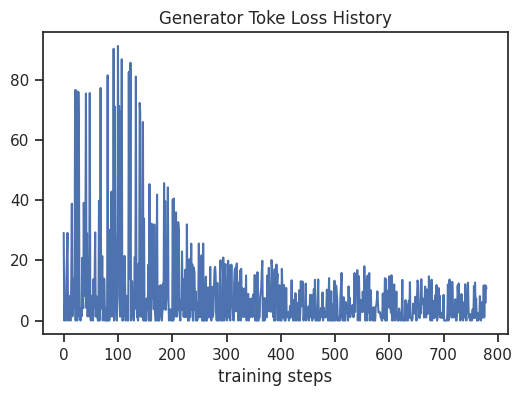

In [225]:
x = range(len(gen_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_token_loss_history)
plt.title('Generator Toke Loss History')
plt.xlabel('training steps')

Text(0.5, 0, 'training steps')

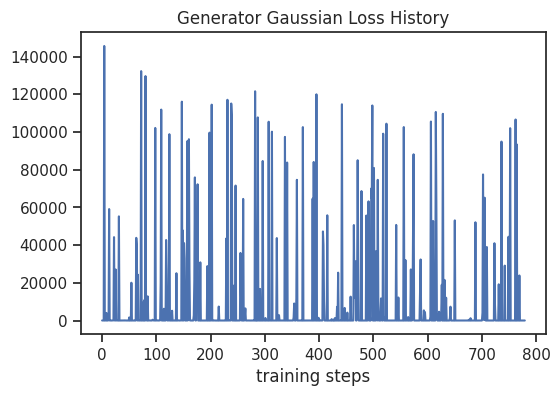

In [226]:
x = range(len(gen_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_gaussian_loss_history)
plt.title('Generator Gaussian Loss History')
plt.xlabel('training steps')

Text(0.5, 0, 'training steps')

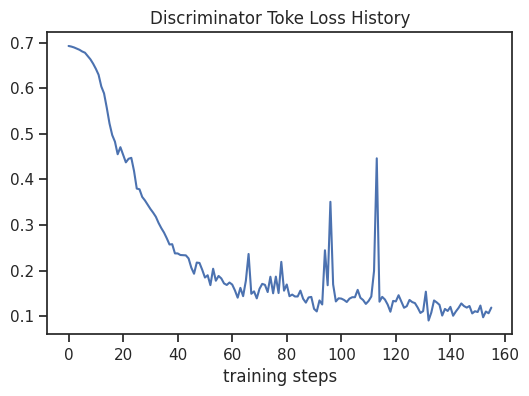

In [227]:
x = range(len(disc_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_token_loss_history)
plt.title('Discriminator Toke Loss History')
plt.xlabel('training steps')

Text(0.5, 0, 'training steps')

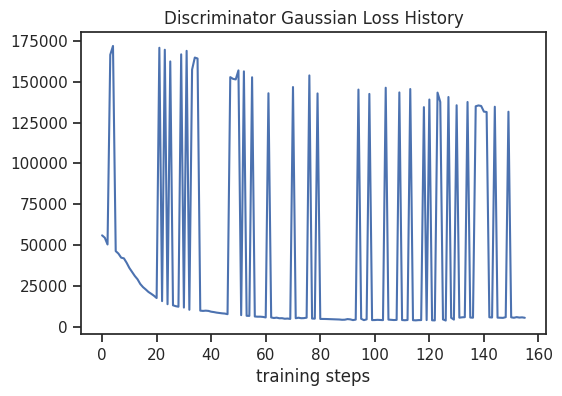

In [228]:
x = range(len(disc_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_gaussian_loss_history)
plt.title('Discriminator Gaussian Loss History')
plt.xlabel('training steps')

## Generate sequences after training

In [229]:
# states_et, states_ts, episode_token_probs, gaussian_log = generate_one_seq(generator)
# states_et.squeeze()

def recover_timedelta_to_timestamp(time_seq):
    csum = []
    curr = 0
    
    for dt in time_seq:
        if dt != 0:
            curr += dt
            csum.append(curr)
        else:
            csum.append(0)
    
    return csum

# recover_timedelta_to_timestamp(time_seq)

In [230]:
N_gen = 1000 # 
generated_seqs = []

for i in range(N_gen):
    states_et, states_ts, episode_token_probs, gaussian_log = generate_one_seq(generator)
    type_seq = states_et[-1,:,:].squeeze().tolist()
    time_seq = states_ts[-1,:,:].squeeze().tolist()
    recovered_time_seq = recover_timedelta_to_timestamp(time_seq)
    generated_seqs.append(list(zip(type_seq, recovered_time_seq)))
    if i % 50 == 0: 
        print(i)
        print(list(zip(type_seq, recovered_time_seq)))

0
[(0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]
50
[(3.0, 1.0), (2.0, 2.0), (2.0, 3.0), (2.0, 4.0), (2.0, 5.0), (3.0, 6.0), (1.0, 7.0), (2.0, 8.0), (1.0, 9.0), (1.0, 10.0)]
100
[(1.0, 1.0), (1.0, 2.0), (3.0, 3.0), (3.0, 4.0), (2.0, 5.0), (1.0, 6.0), (2.0, 7.0), (2.0, 8.0), (0.0, 0), (0.0, 0)]
150
[(1.0, 1.309724526890685), (1.0, 2.309724526890685), (2.0, 3.309724526890685), (3.0, 4.309724526890685), (1.0, 5.7177860210971705), (1.0, 6.7177860210971705), (1.0, 7.750033971510817), (1.0, 8.750033971510817), (0.0, 0), (0.0, 0)]
200
[(3.0, 1.0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]
250
[(0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]
300
[(3.0, 1.0), (3.0, 2.0), (2.0, 3.0), (2.0, 4.0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]
350
[(2.0, 1.0), (1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)

In [231]:
import os 
import pickle

generated_seqs_filename = 'experiment_5.pickle'

with open(os.path.join(os.getcwd(), 'experiment_results', generated_seqs_filename), 'wb') as f:
    pickle.dump(generated_seqs, f)

## Calculate Oracle Scores for generated seqs

In [232]:
import numpy as np
import matplotlib.pyplot as plt

# A: start, B: click, C:install
EVENT_TYPES = {1:'A', 2:'B', 3:'C'} # 0 is reserved for padding
EVENT_ENCODE = {'A':1, 'B':2, 'C':3}
MAX_BC_DELAY = 60

def get_oracle_score(seq):
    score = 0
    
    # if the seq follows starting rule, add 0.5 points to score
    score += 0.5 * int(seq[0][0] == EVENT_ENCODE['A'])
    
    # The rest 0.5 points is weighted by (number of paired C events) / (number of total C events)
    # one-pass: add C to queue to be attributed to the first available B in a reversed linear scanning
    total_C = 0
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if seq[i][0] == EVENT_ENCODE['C']: # encounter a C event
            queue.append(i)
            total_C += 1
        elif seq[i][0] == EVENT_ENCODE['B'] and queue: # encounter a B event
            if seq[queue[0]][1] - seq[i][1] <= MAX_BC_DELAY:
                queue.pop(0)
            else: # ealy-stopping, since no possible B in future can be pair with the C on top of the queue
                return False
    unmatched_C = len(queue)
    
    if total_C > 0:
        score += 0.5 * (1 - unmatched_C / total_C)
    else:
        # if no C event, the seq can easily be valid
        # but we penalize this case by reducing total score by 0.05
        # to encourage the GAN generator to generate C events
        score += 0.45 
    
    return score

## True data

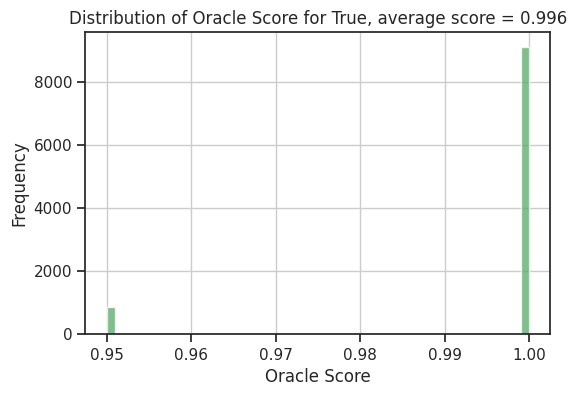

In [210]:
valid_seqs

scores_for_true = np.array([get_oracle_score(seq) for seq in valid_seqs])

x = scores_for_true

plt.figure(dpi=100)
n, bins, patches = plt.hist(x, 50, density=False, facecolor='g', alpha=0.75)

plt.xlabel('Oracle Score')
plt.ylabel('Frequency')
plt.title('Distribution of Oracle Score for True, average score = ' + str(round(sum(x)/len(x), 3)))
# plt.xlim(0, 1.1)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

### benchmark : randomly generated sequences

In [222]:
benchmark_seqs = []

while len(benchmark_seqs) < N_gen:
    # Generate a seq of timestamps. Time delta follows Chi-Square(10)
    time_seq = np.cumsum([int(np.ceil(np.random.chisquare(df=10))) for _ in range(10)]).tolist()
        
    # manualy apply rule 2
    type_seq = np.random.randint(low=EVENT_ENCODE['A'], high=EVENT_ENCODE['C']+1, size=T).tolist()
    
    benchmark_seqs.append(list(zip(type_seq, time_seq)))

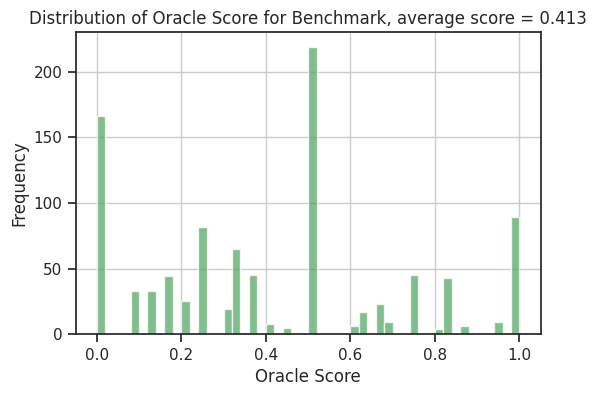

In [223]:
scores_for_benchmark = np.array([get_oracle_score(seq) for seq in benchmark_seqs])

x = scores_for_benchmark

plt.figure(dpi=100)
n, bins, patches = plt.hist(x, 50, density=False, facecolor='g', alpha=0.75)

plt.xlabel('Oracle Score')
plt.ylabel('Frequency')
plt.title('Distribution of Oracle Score for Benchmark, average score = ' + str(round(sum(x)/len(x), 3)))
# plt.xlim(0, 1.1)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

### experiment 1: 20 total steps, no loss weighting

In [207]:
data_path = '/home/lun/project-basileus/seq-gan/experiment_results/experiment_1.pickle'

with open(data_path, 'rb') as f:
    experiment_1_seqs = pickle.load(f)

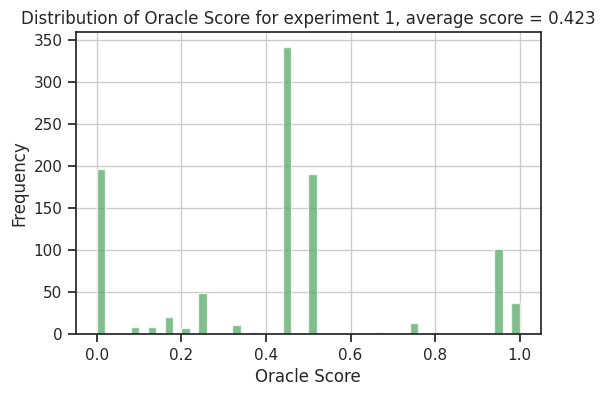

In [208]:
scores = np.array([get_oracle_score(seq) for seq in experiment_1_seqs])

x = scores

plt.figure(dpi=100)
n, bins, patches = plt.hist(x, 50, density=False, facecolor='g', alpha=0.75)

plt.xlabel('Oracle Score')
plt.ylabel('Frequency')
plt.title('Distribution of Oracle Score for experiment 1, average score = ' + str(round(sum(x)/len(x), 3)))
# plt.xlim(0, 1.1)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

### experiment 2: 20 total steps, with gaussian loss weighted by 1e-3

In [165]:
data_path = '/home/lun/project-basileus/seq-gan/experiment_results/experiment_2.pickle'

with open(data_path, 'rb') as f:
    experiment_2_seqs = pickle.load(f)

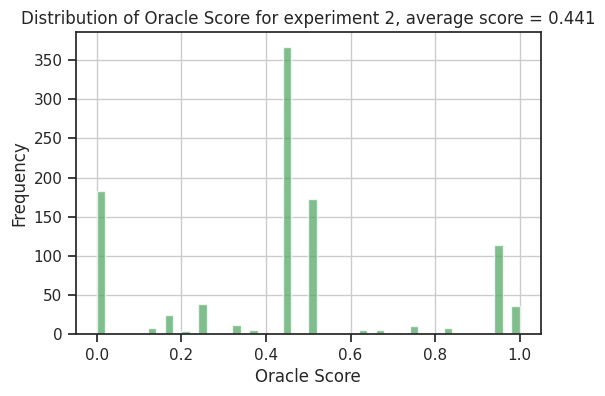

In [166]:
scores = np.array([get_oracle_score(seq) for seq in experiment_2_seqs])

x = scores

plt.figure(dpi=100)
n, bins, patches = plt.hist(x, 50, density=False, facecolor='g', alpha=0.75)

plt.xlabel('Oracle Score')
plt.ylabel('Frequency')
plt.title('Distribution of Oracle Score for experiment 2, average score = ' + str(round(sum(x)/len(x), 3)))
# plt.xlim(0, 1.1)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

### experiment 3: 80 total steps (around 1 epoch), with gaussian loss weighted by 1e-3

In [205]:
data_path = '/home/lun/project-basileus/seq-gan/experiment_results/experiment_3.pickle'

with open(data_path, 'rb') as f:
    experiment_3_seqs = pickle.load(f)

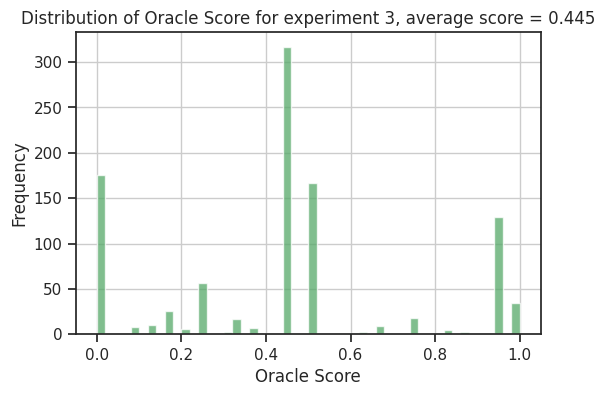

In [206]:
scores = np.array([get_oracle_score(seq) for seq in experiment_3_seqs])

x = scores

plt.figure(dpi=100)
n, bins, patches = plt.hist(x, 50, density=False, facecolor='g', alpha=0.75)

plt.xlabel('Oracle Score')
plt.ylabel('Frequency')
plt.title('Distribution of Oracle Score for experiment 3, average score = ' + str(round(sum(x)/len(x), 3)))
# plt.xlim(0, 1.1)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

### experiment 4: 20 total steps, no gaussian loss

In [220]:
data_path = '/home/lun/project-basileus/seq-gan/experiment_results/experiment_4.pickle'

with open(data_path, 'rb') as f:
    experiment_4_seqs = pickle.load(f)

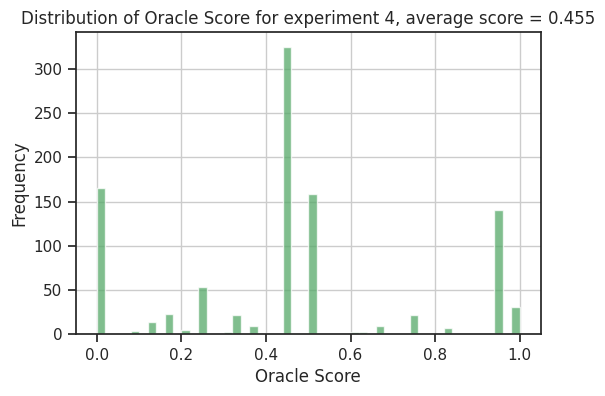

In [221]:
scores = np.array([get_oracle_score(seq) for seq in experiment_4_seqs])

x = scores

plt.figure(dpi=100)
n, bins, patches = plt.hist(x, 50, density=False, facecolor='g', alpha=0.75)

plt.xlabel('Oracle Score')
plt.ylabel('Frequency')
plt.title('Distribution of Oracle Score for experiment 4, average score = ' + str(round(sum(x)/len(x), 3)))
# plt.xlim(0, 1.1)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

### experiment 5: 80 total steps, no gaussian loss

In [233]:
data_path = '/home/lun/project-basileus/seq-gan/experiment_results/experiment_5.pickle'

with open(data_path, 'rb') as f:
    experiment_5_seqs = pickle.load(f)

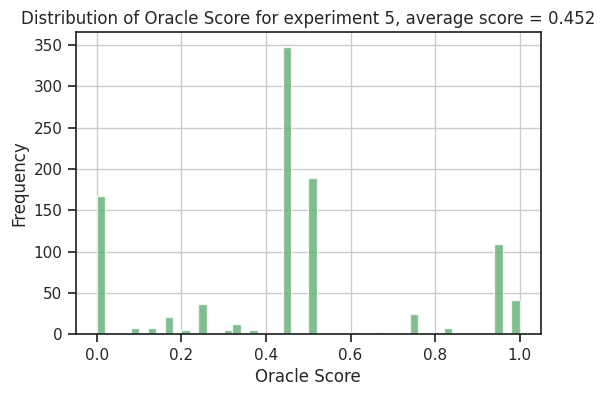

In [234]:
scores = np.array([get_oracle_score(seq) for seq in experiment_5_seqs])

x = scores

plt.figure(dpi=100)
n, bins, patches = plt.hist(x, 50, density=False, facecolor='g', alpha=0.75)

plt.xlabel('Oracle Score')
plt.ylabel('Frequency')
plt.title('Distribution of Oracle Score for experiment 5, average score = ' + str(round(sum(x)/len(x), 3)))
# plt.xlim(0, 1.1)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

## debug section

In [ ]:
data_path = '/home/lun/project-basileus/seq-gan/experiment_results/experiment_1.pickle'

with open(data_path, 'rb') as f:
    experiment_1_seqs = pickle.load(f)

In [ ]:
# e1_et_seqs = []
# e1_ts_seqs = []
# # e1_ts = recover_timedelta_to_timestamp(e1_dt)

# for e1 in experiment_1_seqs:
#     et_seq, dt_seq = tuple(zip(*e1))
#     recovered_ts_seq = recover_timedelta_to_timestamp(dt_seq)
#     e1_et_seqs.append(et_seq)
#     e1_ts_seqs.append(recovered_ts_seq)

# experiment_1_seqs = new_experiment_1_seqs = [list(zip(e1_et_seqs[i], e1_ts_seqs[i])) for i in range(len(e1_et_seqs))]

# import os 
# import pickle

# generated_seqs_filename = 'experiment_1.pickle'

# with open(os.path.join(os.getcwd(), 'experiment_results', generated_seqs_filename), 'wb') as f:
#     pickle.dump(experiment_1_seqs, f)